# FastText experiments

Some experiments using the pre-trained fastText model.

## Downloading the pre-trained model

The pre-trained model can be downloaded here:

https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md


In this notebook we are going to use the Simple Wikipedia model in vec format.

https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.zip


Note that the file is pretty big and loading it takes some time.

## Loading the word vectors using Gensim

In [30]:
from gensim.models.wrappers import FastText

embeddings_index = FastText.load_word2vec_format('fasttext/wiki.simple.vec')

The word vectors have shape 300:

In [31]:
embeddings_index['hockey'].shape

(300,)

## Loading the 20 newsgroups dataset

In [32]:
import re
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian','comp.graphics','sci.med']

train_set = fetch_20newsgroups(subset='train',
                           categories=categories,
                           remove=('headers', 'footers', 'quotes'),
                           shuffle=True, 
                           random_state=42)

test_set = fetch_20newsgroups(subset='test',                          
                          categories=categories,
                          remove=('headers', 'footers', 'quotes'),
                          shuffle=True, 
                          random_state=42)

texts = np.append(train_set.data, test_set.data)
labels = np.append(train_set.target, test_set.target)

print("Total documents: %d"%(len(texts)))
print("Total labels: %d"%(len(labels)))
print("Train documents: %d"%(len(train_set.data)))
print("Test documents: %d"%(len(test_set.data)))

Total documents: 3759
Total labels: 3759
Train documents: 2257
Test documents: 1502


## Vectorize the texts

In [33]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=1000)
labels = to_categorical(np.asarray(labels))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 39083 unique tokens.
Shape of data tensor: (3759, 1000)
Shape of label tensor: (3759, 4)


## Split the data into a training and testing set

In [34]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(0.2 * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

## Build embeddings matrix

In [43]:
w2v = {w: vec for w, vec in zip(embeddings_index.index2word, embeddings_index.syn0)}

num_words = min(20000, len(word_index))
embedding_matrix = np.zeros((num_words, 300))
for word, i in word_index.items():
    if i >= 20000:
        continue
    if word in w2v:
        embedding_matrix[i] = w2v[word]
        
embedding_matrix.shape

(20000, 300)

## Keras CNN

Based on: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [44]:
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

Define the frozen embedding layer:

In [45]:
embedding_layer = Embedding(num_words,
                            300,
                            weights=[embedding_matrix],
                            input_length=1000,
                            trainable=False)

Define CNN model:

In [48]:
sequence_input = Input(shape=(1000,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(categories), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 300)         6000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 996, 128)          192128    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 35, 128)           82048     
__________

In [50]:
%%time

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))

print("Model trained.")

scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 3008 samples, validate on 751 samples
Epoch 1/10
3008/3008 [==============================] - 50s - loss: 0.3035 - acc: 0.8790 - val_loss: 0.5095 - val_acc: 0.7843
Epoch 2/10
3008/3008 [==============================] - 50s - loss: 0.2837 - acc: 0.8836 - val_loss: 0.4249 - val_acc: 0.8309
Epoch 3/10
3008/3008 [==============================] - 50s - loss: 0.2185 - acc: 0.9136 - val_loss: 0.6071 - val_acc: 0.8016
Epoch 4/10
3008/3008 [==============================] - 49s - loss: 0.2472 - acc: 0.9082 - val_loss: 0.4220 - val_acc: 0.8455
Epoch 5/10
3008/3008 [==============================] - 49s - loss: 0.2550 - acc: 0.9132 - val_loss: 0.4134 - val_acc: 0.8495
Epoch 6/10
3008/3008 [==============================] - 49s - loss: 0.1582 - acc: 0.9398 - val_loss: 0.4387 - val_acc: 0.8495
Epoch 7/10
3008/3008 [==============================] - 49s - loss: 0.1850 - acc: 0.9378 - val_loss: 0.4183 - val_acc: 0.8535
Epoch 8/10
3008/3008 [==============================] - 50s - loss: 0.1

## Visualize training accuracy and loss

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

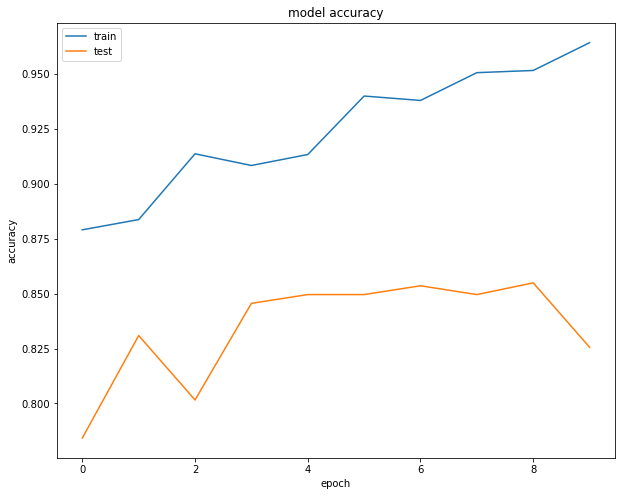

In [55]:
# summarize history for accuracy
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

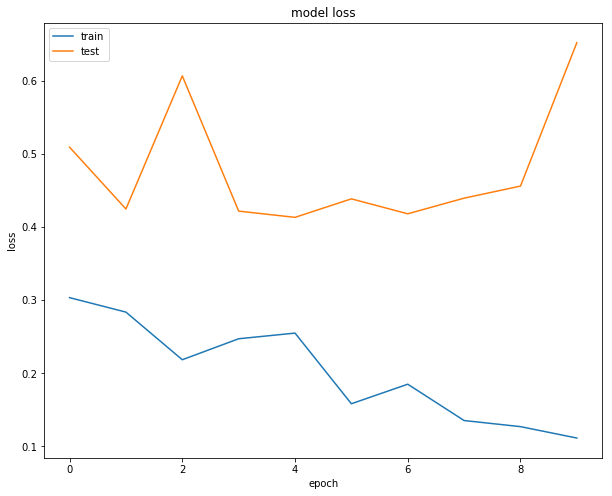

In [56]:
# summarize history for loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()